# Ant Colony Optimization

In [1]:
import osmnx as ox
import networkx as nx
from IPython.display import IFrame, HTML
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import sys, random
from tqdm import tqdm
from utilities import *

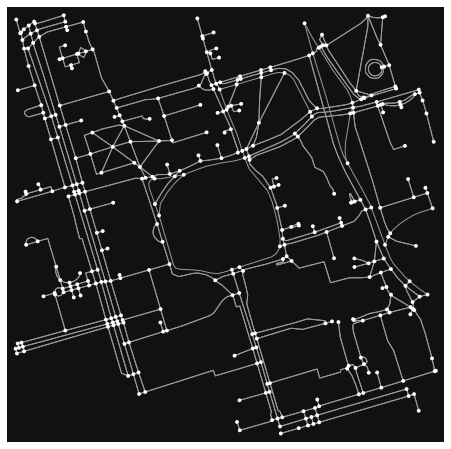

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

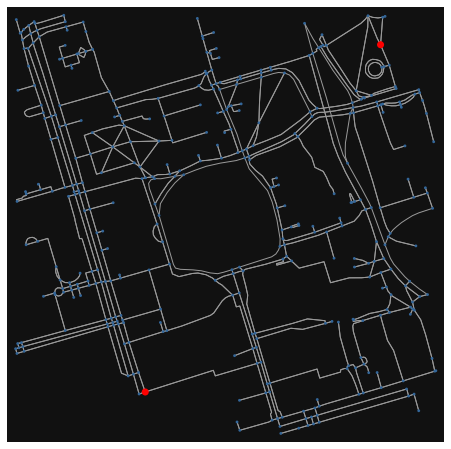

In [3]:
# marking both the source and destination node

nc = ['r' if node == 389677909 or node == 55808290 else '#336699' for node in G.nodes()]
ns = [50 if node == 389677909 or node == 55808290 else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
%%capture
source(Node)

In [82]:
origin = Node(graph = G, osmid = 55808290)
destination = Node(graph = G, osmid = 389677909)

In [95]:
alpha = 7
beta = 2

In [96]:
phermone_concentration = dict()

In [97]:
for edge in G.edges():
    u = edge[0]
    v = edge[1]
    phermone_concentration[(u, v)] = random.uniform(0,0.5)

In [98]:
routes = dict()   # all the routes choosen by all the ants

for ant in tqdm(range(10)):
    # put an ant on the origin node
    frontier = [origin]
    explored = set()
    route = []
    found = False
    
    while frontier and not found:
        # we will be doing a very verbose graph traversal but
        # with probabilistically choosing the children based
        # on the phermone concentration deposited betweeen
        # the parent at the current iteration and that child
        parent = frontier.pop(0)
        explored.add(parent)
        
        children = []
        children_phermone_smell = []
        # we will need to expand all the children to choose what edge to take
        for child in parent.expand():
            # if we can reach destination from current node we go to it anyway
            if child == destination: 
                found = True; route = child.path();continue
            if child not in explored:
                children.append(child)
                children_phermone_smell.append((phermone_concentration[(parent.osmid, child.osmid)])**alpha * ((1/child.distance))**beta)
        
        # the ant is stuck
        if len(children) == 0: continue
            
        # computing the transition probability for each child
        transitionProbability = [((phermone_concentration[(parent.osmid, child.osmid)])**alpha * (1/child.distance)**beta)/sum(children_phermone_smell) for child in children]
        
        # probabilistically choose the child based on their transition probability
        choosen = random.choices(children, weights = transitionProbability, k = 1)[0]
        
        # add all the children before the choosen one
        # in case it get stuck at that node the ant
        # could resort to these nodes and go back
        for child in children:
            if child != choosen:
                frontier.insert(0, child)
                
        # AGAIN please track how the frontier stack is filled
        # you will see how the "ant" go down some path
        # and if this path is blocked (no children) we go back
        # to an "expandable node" --- this is crucial thing to understand
        frontier.insert(0, choosen)
        
    # now we have our route that the ant went through
    # let's update the phermone concentration over it 
    # we are following ant quantity model for online step by step phermone model
    
    # choosing Q should be totally dependent on the problem on hand
    # by looking the length of edges Q equals to 1 seems like a fair choice
    Q = 1
    for u, v in zip(route, route[1:]):
        length_of_edge = G[u][v][0]['length']
        phermone_concentration[(u,v)] += Q/length_of_edge
        
    # if this route has not ever been taken before
    # added it to the routes dictionary -- tuple conversion is only here to deal with python dictionary hashing
    route = tuple(route)    
    if route in routes:
        routes[route] += 1
    else: # we have seen this route before 
        routes[route] = 1
        
        
    
    
    

100%|██████████| 10/10 [00:00<00:00, 352.83it/s]


getting the most route that ants has traversed and see how many ants choose that path

In [99]:
# the route with the most number of ants
route = max(routes, key=routes.get)


In [100]:
# number of ants
routes[route]

2

In [101]:
# un-hash the route :")
route = list(route)

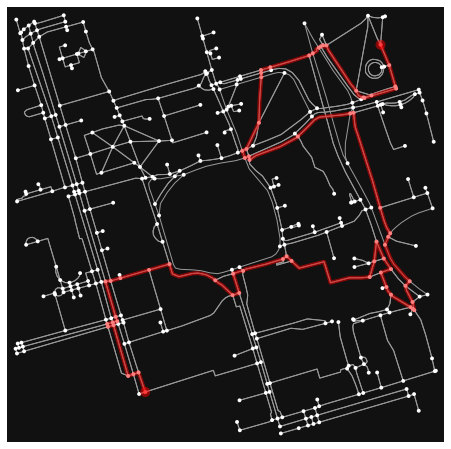

In [102]:
fig, ax = ox.plot_graph_route(G, route)


In [103]:
cost(G, route)

1791.342